# A visualisation of the Birmingham 'Scoots' data

Scoots are the cables often seen laid across roads. They are sensors that capture the speed of vehicles crossing them. 

In [1]:
%matplotlib inline

import pymongo
import pandas as pd
import numpy as np

import matplotlib.cm
import matplotlib.pyplot as plt

from pymongo import MongoClient
from mpl_toolkits.basemap import Basemap

In [2]:
client = MongoClient('localhost', 27017)

In [3]:
client.database_names()

['admin', 'config', 'local', 'test', 'users']

In [4]:
db = client.test
collection = db.sensor

dictholder = {}

In [5]:
for it in collection.find():
    dictholder[str(it['_id'])] = {key:it[key] for key in it.keys() - {'_id'}}

In [6]:
df = pd.DataFrame(dictholder).T.reset_index()
df.columns = ['sensor'] + list(df.columns[1:])

In [7]:
df.head()

,sensor,bearing,compass,easting,last_update,lat,location,lon,northing,scoot_id,system_code_number
0,5acf66f1bd8a660c745e00f8,,,0,2018-02-12 12:20:55,,,,0,201,N24211B
1,5acf66f1bd8a660c745e00f9,,,0,2016-01-05 16:41:42,,,,0,692,N63132B
2,5acf66f1bd8a660c745e00fa,,,0,2018-02-12 12:20:55,,,,0,203,N24211E
3,5acf66f1bd8a660c745e00fb,,,410459,2017-06-01 09:07:39,,,,290130,850,N74212Y
4,5acf66f1bd8a660c745e00fc,,,0,2017-08-08 22:49:34,,,,0,898,N81132C


In [10]:
df.groupby('scoot_id').first().shape

(1077, 10)

In [11]:
df[df['lon']!=''].shape

(360, 11)

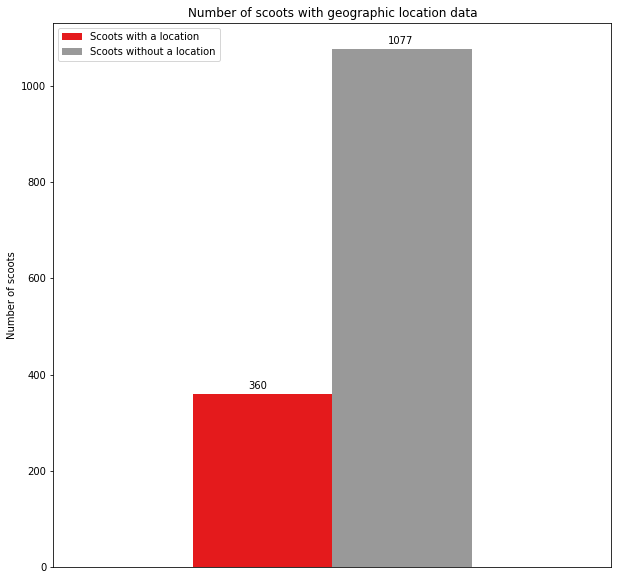

In [16]:
fig, ax = plt.subplots(figsize=((10,10)))
pd.DataFrame({'Scoots without a location':1077, 'Scoots with a location':360}, index=[1]).plot(kind='bar', ax=ax, cmap='Set1')

ax.set_ylabel('Number of scoots')
ax.set_title('Number of scoots with geographic location data')
ax.set_xticks([])
ax.text(0.1, 1087, '1077')
ax.text(-0.15, 370, '360');

In [8]:
lons = []
lats = []
for row in df[df['lon']!=''].itertuples():
    lons.append(row.lon)
    lats.append(row.lat)

C:\Users\James\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1704: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  limb = ax.axesPatch
C:\Users\James\Anaconda3\lib\site-packages\mpl_toolkits\basemap\__init__.py:1707: MatplotlibDeprecationWarning: The axesPatch function was deprecated in version 2.1. Use Axes.patch instead.
  if limb is not ax.axesPatch:


Wall time: 1min 17s


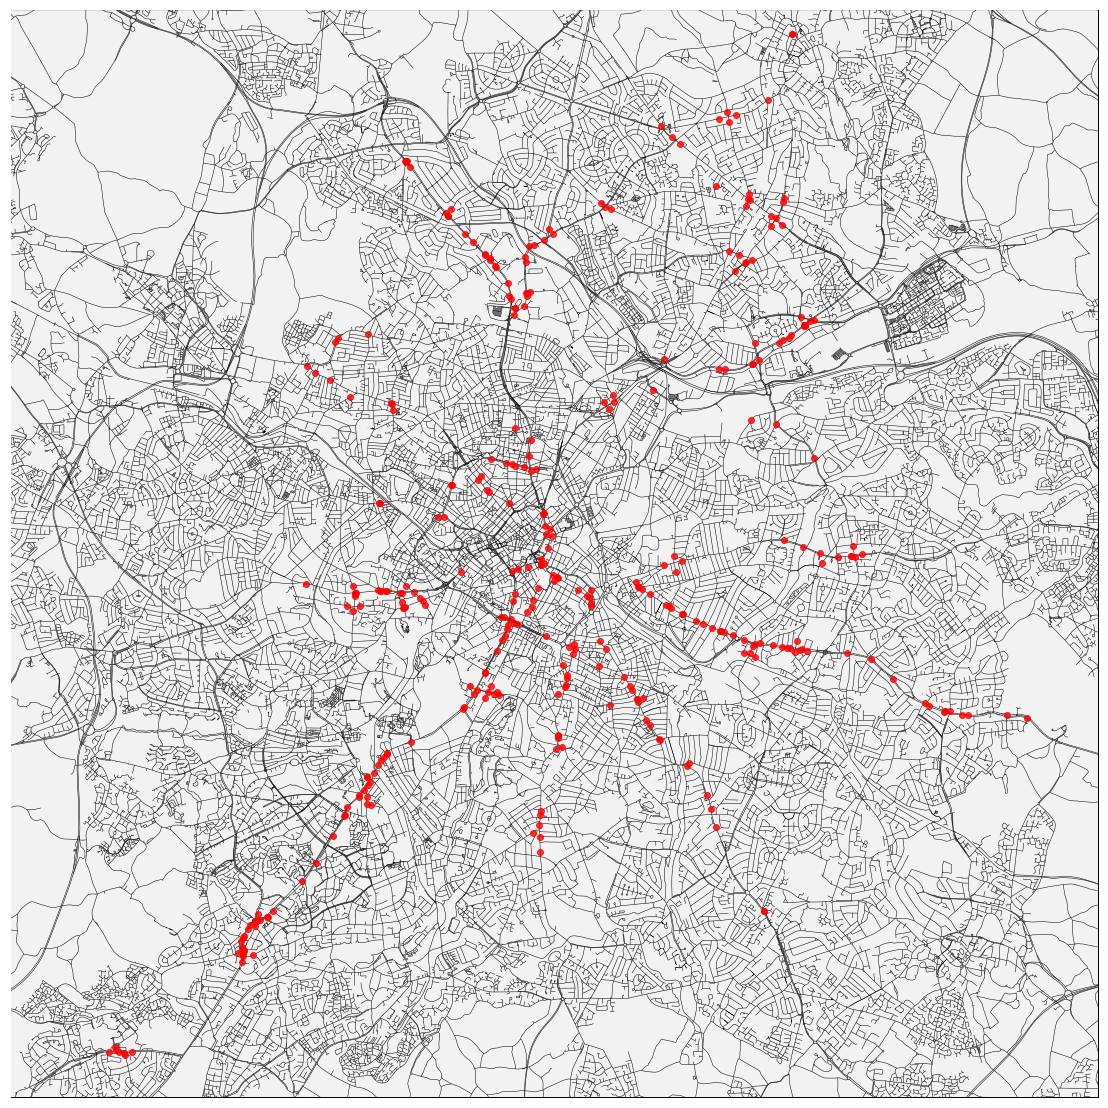

In [9]:
%%time
fig= plt.figure(figsize=(20,20))


m = Basemap(resolution='c',
            projection='tmerc',
            lat_0=52.4782, lon_0=-1.889, width=20000, height = 20000)
            #llcrnrlon=-2, llcrnrlat=51.418, urcrnrlon=-0.8, urcrnrlat=52.504)

m.drawmapboundary(fill_color='white', zorder=0)
m.fillcontinents(color='#f2f2f2',lake_color='#46bcec', zorder=1)
m.drawcoastlines(zorder=2)
#m.readshapefile("D:\Html pages\Distribution\Areas", 'areas', zorder=3)
m.readshapefile(r"D:\Html pages\roads", 'roads', zorder=4)

#y, x = m(52.4782, -1.889)

m.plot(lons,lats, 'ko', latlon=True, zorder=10, color='red', alpha=0.8);

In [26]:
db = client.users
scoots = db.scoots_data_MSC

In [28]:
scoots.count()

211194123

In [27]:
scoots.find_one()

{'_id': ObjectId('5ad25fd14886f224963c1413'),
 'congestion': 0,
 'entry_id': 5149162,
 'flow': 0,
 'occupancy': 0,
 'scoot_id': 31,
 'speed': 0,
 'travel_time': 0,
 'travel_time_status': 0,
 'travel_time_type': 1,
 'update_time': '2015-05-26 05:57:55'}

In [39]:
actives = df[df['lon']!='']['scoot_id'].tolist()

In [125]:
active_dict_day = {}
active_dict_dayhour = {}

for scoot in actives[]:

    
    df2 = pd.DataFrame.from_records(scoots.find({'scoot_id':scoot}))
    df2['update_time'] = pd.to_datetime(df2['update_time'])
    df2['hour'] = df2['update_time'].apply(lambda x : x.hour)
    df2['date'] = df2['update_time'].apply(lambda x : x.date())
    df2['weekday'] = df2['date'].apply(lambda x: x.weekday())
    
    rush = df2[ ((df2['hour'] == 8 ) | (df2['hour'] == 9)) & (df2['speed'] != 80) ].copy()
    rush['minute'] = pd.to_datetime(rush['update_time']).apply(lambda x: x.minute)
    
    active_dict_day[scoot] = rush.groupby(['weekday'])['speed'].mean().to_dict()
    active_dict_dayhour[scoot] = rush.groupby(['weekday','hour','minute'])['speed'].mean().to_dict()